In [141]:
k = 10
mu = np.zeros(k)
# seed(1)
for i in range(k):
  mu[i] = random()
beta_distn_reward = []
beta_distn_cost = []
cost = np.zeros(k)
# seed(1)
for i in range(k):
    cost[i] = random()
B = budget = 50000
T = 1000
print (mu)
print (cost)

[0.30336851 0.58758061 0.882479   0.84619742 0.50528382 0.58900226
 0.03452583 0.24273997 0.79740425 0.414314  ]
[0.1730074  0.54879876 0.70304076 0.67448583 0.37470302 0.43896163
 0.50842649 0.77844262 0.52093842 0.39325509]


In [142]:
import numpy as np
from scipy.stats import bernoulli
from random import seed
from random import random

In [140]:
# THOMPSON_SAMPLING_WITHOUT_BUDGET_SETTING

for i in range(k):
    beta_distn_reward.append([0.0,0.0])

sampled_mean_reward = np.array([0]*k)
for t in range(T):
    for arm in range(k):
        sampled_mean_reward[arm] = np.random.beta(beta_distn_reward[arm][0]+1, beta_distn_reward[arm][1]+1)
    arm_pulled = np.argmax(sampled_mean_reward)
    reward_received = bernoulli.rvs(mu[arm_pulled], size=1)[0]
    beta_distn_reward[arm_pulled][0] += reward_received
    beta_distn_reward[arm_pulled][1] += (1-reward_received)


In [143]:
# THOMPSON_SAMPLING_WITH_BUDGET_SETTING

for i in range(k):
    beta_distn_reward.append([0.0,0.0])

for i in range(k):
    beta_distn_cost.append([0.0,0.0])

regret = []
best_arm = np.argmax(mu/cost)

reward_records = []
arm_pulled_records = []

sampled_mean_reward = np.array([0]*k, dtype=np.float)
sampled_mean_cost = np.array([0]*k, dtype=np.float)

while budget>0:
    for arm in range(k):
        sampled_mean_reward[arm] = np.random.beta(beta_distn_reward[arm][0]+1, beta_distn_reward[arm][1]+1)
        sampled_mean_cost[arm] = np.random.beta(beta_distn_cost[arm][0]+1, beta_distn_cost[arm][1]+1)
        arm_pulled = np.argmax(sampled_mean_reward/sampled_mean_cost)
        reward_received = bernoulli.rvs(mu[arm_pulled], size=1)[0]
        cost_received = bernoulli.rvs(cost[arm_pulled], size=1)[0]
        budget -= cost_received
        reward_records.append(reward_received)
        arm_pulled_records.append(arm_pulled)
        beta_distn_reward[arm_pulled][0] += reward_received
        beta_distn_reward[arm_pulled][1] += (1-reward_received)
        beta_distn_cost[arm_pulled][0] += cost_received
        beta_distn_cost[arm_pulled][1] += (1-cost_received)



In [144]:
# cumulative_reward = 0.0
# print (best_arm)
# print (reward_records)
regret_record = []
sum_regret = 0.0
for i in range(B):
    # cumulative_reward += reward_records[i]
    # print(cumulative_reward)
    # print (((i+1)/cost[best_arm])*mu[best_arm])
    # regret.append((((i+1)/cost[best_arm])*mu[best_arm]) - cumulative_reward)
    arm_pulled = arm_pulled_records[i]
    sum_regret += cost[arm_pulled]*(mu[best_arm]/cost[best_arm] - mu[arm_pulled]/cost[arm_pulled])
    regret_record.append(sum_regret)


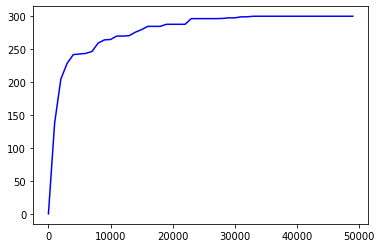

In [145]:
import matplotlib.pyplot as plt
interval = 1000
t = range(0,B,interval)
regret_plot_record = []
for i in range(0,B,interval):
    regret_plot_record.append(regret_record[i])
plt.plot(t, regret_plot_record, 'b-', label='ThompsonSampling regret')